In [101]:
import keras
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Dense, Input, Dropout, Flatten, Activation, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.utils.np_utils import to_categorical  
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
import json
import pickle
K.set_image_dim_ordering('tf') 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def show_img(img):
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        img2 = img
        plt.imshow(img2, cmap='gray')
        plt.show()

In [3]:
%load_ext autoreload
%autoreload 2
from utils.preprocess_utils import *
SHAPE = (64, 64)
CHANNEL = 3

In [4]:
with open(train_data_name, 'rb') as f:
    train_data = pickle.load(f)
with open(test_data_name, 'rb') as f:
    test_data = pickle.load(f)
train_formatter = DataFormatter(train_data, train_folders, SHAPE, channel=CHANNEL, add_neg=False)
train_data = train_formatter.get_formatted_data_for_modeling()
test_formatter = DataFormatter(test_data, test_folders, SHAPE, channel=CHANNEL, add_neg=False)
test_data = test_formatter.get_formatted_data_for_modeling()

dataset: (33392, 64, 64, 3)
labels: (33392, 6)
dataset: (13066, 64, 64, 3)
labels: (13066, 6)


In [4]:
train_img_size = (64, 64)

In [5]:
train_images, train_labels = get_detecting_imgages_labels(train_formatter, train_img_size)

In [6]:
test_images, test_labels = get_detecting_imgages_labels(test_formatter, train_img_size)

# Train CNN

In [8]:
k_size = 3
cnn1 = Input(shape=(64, 64, 1))
#x = BatchNormalization()(cnn1)
x = Conv2D(32, k_size, k_size, activation='relu', border_mode='same')(cnn1)
x = BatchNormalization()(x)
x = Conv2D(32, k_size, k_size, activation='relu', border_mode='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, k_size, k_size, activation='relu', border_mode='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, k_size, k_size, activation='relu', border_mode='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(128, k_size, k_size, activation='relu', border_mode='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, k_size, k_size, activation='relu', border_mode='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
h = Dense(4)(x)

model = Model(input=cnn1, output=h)
model.compile(loss='mse', optimizer='adadelta')

/home/mosaic/.conda/envs/airbus/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/home/mosaic/.conda/envs/airbus/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
/home/mosaic/.conda/envs/airbus/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/mosaic/.conda/envs/airbus/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/home/mosaic/.conda/envs/airbus/lib/python3.6/site-packages/ipykernel_launche

In [9]:
model_checkpointer = keras.callbacks.ModelCheckpoint(filepath='saved_models/detection_model.hdf5',
                                                     monitor='loss',
                                                     save_best_only=True,
                                                     verbose=2)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                              factor=0.1,
                                              verbose=1,
                                              patience=4,
                                              cooldown=1,
                                              min_lr=0.0001)
callback = [model_checkpointer, reduce_lr]
model.fit(train_images, train_labels, 
          epochs=50, batch_size=128, 
          validation_split=0.2, verbose=1,
           callbacks=callback
         )

Train on 26713 samples, validate on 6679 samples
Epoch 1/50
26713/26713 [==============================] - 19s 706us/step - loss: 188.8151 - val_loss: 60.2495

Epoch 00001: loss improved from inf to 188.81509, saving model to saved_models/detection_model.hdf5
Epoch 2/50
26713/26713 [==============================] - 15s 566us/step - loss: 19.6052 - val_loss: 41.9977

Epoch 00002: loss improved from 188.81509 to 19.60521, saving model to saved_models/detection_model.hdf5
Epoch 3/50
26713/26713 [==============================] - 15s 561us/step - loss: 16.7940 - val_loss: 29.1340

Epoch 00003: loss improved from 19.60521 to 16.79404, saving model to saved_models/detection_model.hdf5
Epoch 4/50
26713/26713 [==============================] - 15s 561us/step - loss: 14.9614 - val_loss: 41.4382

Epoch 00004: loss improved from 16.79404 to 14.96142, saving model to saved_models/detection_model.hdf5
Epoch 5/50
26713/26713 [==============================] - 15s 561us/step - loss: 12.6403 - val_lo


Epoch 00040: loss did not improve from 1.20636
Epoch 41/50
26713/26713 [==============================] - 15s 567us/step - loss: 1.1950 - val_loss: 23.5579

Epoch 00041: loss improved from 1.20636 to 1.19498, saving model to saved_models/detection_model.hdf5
Epoch 42/50
26713/26713 [==============================] - 15s 562us/step - loss: 1.1326 - val_loss: 22.1772

Epoch 00042: loss improved from 1.19498 to 1.13256, saving model to saved_models/detection_model.hdf5
Epoch 43/50
26713/26713 [==============================] - 15s 562us/step - loss: 1.1007 - val_loss: 17.6062

Epoch 00043: loss improved from 1.13256 to 1.10065, saving model to saved_models/detection_model.hdf5
Epoch 44/50
26713/26713 [==============================] - 15s 564us/step - loss: 1.1208 - val_loss: 28.5475

Epoch 00044: loss did not improve from 1.10065
Epoch 45/50
26713/26713 [==============================] - 15s 563us/step - loss: 1.0608 - val_loss: 17.7339

Epoch 00045: loss improved from 1.10065 to 1.0607

In [11]:
preds = model.predict(test_images)
preds[0]

array([ 6.091877, 23.605793, 15.364719, 47.12608 ], dtype=float32)

In [38]:
test_images.shape

(13066, 64, 64, 1)

In [12]:
test_labels[0]

array([ 6, 27, 13, 44])

# Visualize result on test set

In [93]:
%load_ext autoreload
%autoreload 2
from utils.detection_utils import *
from keras.models import load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
model = load_model('saved_models/detection_model.hdf5')

In [18]:
def detect_img_bbox(img, model):
    normalized_img = normalize_img(img, train_img_size)
    normalize_img_input = normalized_img.reshape(1, train_img_size[0], train_img_size[1], 1)
    preds = model.predict(normalize_img_input)[0]
    bbox = preds.astype(int)
    top, left, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
    train_size_bbox = {'left': left, 'right': left + w, 'top': top, 'bottom': top + h}
    org_size_bbox = {
        'left':  max(0, int(left * img.shape[1] / train_img_size[1])),
        'right':  min(img.shape[1] - 1, int((left + w) * img.shape[1] / train_img_size[1])),
        'top': max(0, int(top * img.shape[0] / train_img_size[0])),
        'bottom':  min(img.shape[0] - 1, int((top + h) * img.shape[0] / train_img_size[0])),
    }
    return org_size_bbox

def draw_bbox_simple(img, bbox):
    img_copy = img.copy()
    cv2.rectangle(img_copy, (bbox['left'], bbox['top']), (bbox['right'], bbox['bottom']), (0, 0, 255), 1)
    return img_copy

def visualiza_detection_result(img, model):
    bbox = detect_img_bbox(img, model)
    draw_bbox_rec = draw_bbox(img, bbox)
    show_img(draw_bbox_rec)
    return draw_bbox_rec
    

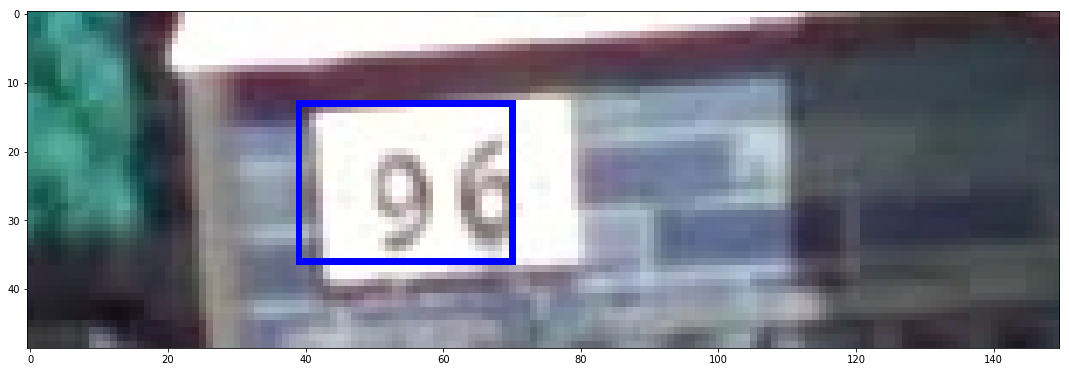

In [80]:
img = cv2.imread('input_images/1.jpg')
result = visualiza_detection_result(img, model)

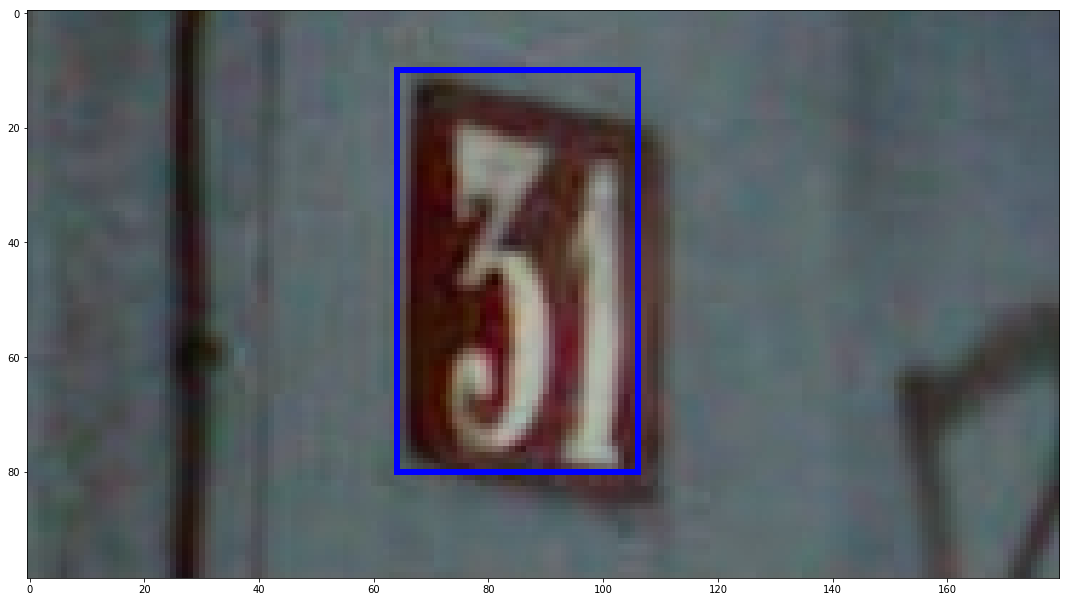

In [17]:
img = cv2.imread('input_images/2.jpg')
result = visualiza_detection_result(img, model)

# detect and predict numbers

In [73]:
vgg_model = load_model('saved_models/VGGPreTrained_classifier_corrected.hdf5')

In [94]:
SIZE = 64
channel = 3

In [95]:
bbox = detect_img_bbox(img, model)

In [96]:
crop_img = crop_img(img, bbox)

In [97]:
normalized_img = normalize_and_scale(crop_img.astype(float))

In [98]:
predict_y = vgg_model.predict(cv2.resize(normalized_img, (SIZE, SIZE)).reshape(1, SIZE, SIZE, channel))

In [99]:
bbox_result  = draw_bbox(bbox, predict_y, img, save_img=False)

[3 1]
99.99993324279785


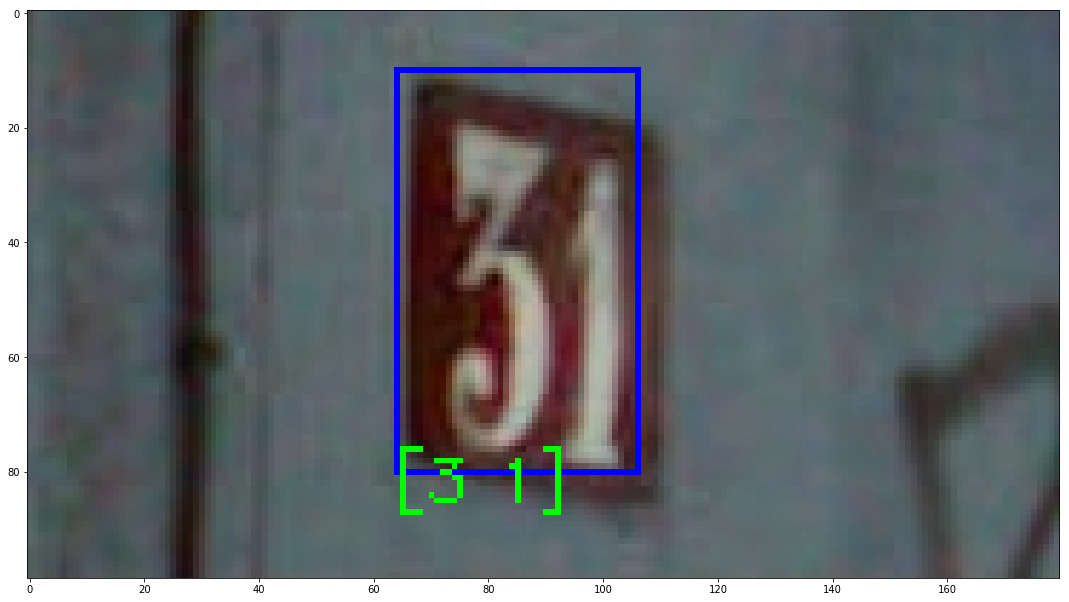

In [100]:
show_img(bbox_result)

In [94]:
def draw_bbox(bbox, preds_probs, img, name='test', save_img=True):
    img_copy = np.copy(img)

    n_digit = np.argmax(preds_probs[0])
    if n_digit == 0:
        print('No digits detected!')
        return
    n_digit_prob = np.max(preds_probs[0])
    seq_probs = np.asarray(preds_probs[1:5]).squeeze()
    seq = np.argmax(seq_probs, axis=1)
    seq_prob = np.max(seq_probs, axis=1)
    avg_prob = (np.sum(seq_prob) + n_digit_prob) / 5.
    detected_bbox = bbox
    cv2.rectangle(img_copy, (detected_bbox[0], detected_bbox[1]), (detected_bbox[2], detected_bbox[3]), (0, 255, 255), 2)
    sequence = seq[seq != 10]
    text1 = str(sequence)
    print(text1)
    conf = avg_prob * 100
    print(conf)
    text2 = 'pred_prob:' + str(('%2.3f' % conf)) + '%'
    org1 = (detected_bbox[0], detected_bbox[1] - 5)
    org2 = (detected_bbox[0], detected_bbox[3] + 5)
    w, d = img.shape[:2]
    font_size = int((w + d) / 20) / 20
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_copy, text1, org1, font, fontScale=font_size, color=(0, 255, 0), lineType=3, thickness=1)
    cv2.putText(img_copy, text2, org2, font, fontScale=font_size, color=(255, 255, 255), lineType=2, thickness=1)
    if save_img == True:
        cv2.imwrite('output/' + name + '.png', img_copy)
    return img_copy